<a href="https://colab.research.google.com/github/VJ627/AML/blob/main/Vjammula_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 4 - Text and Sequence

In [1]:
pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras import preprocessing

from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop

from tensorflow.keras.optimizers import Adam
from google.colab import files
import re, os

Limiting the samples and build the models to understand the importance of training samples and its effect on the model performance.

Model 1

In [3]:
#maximum number of words
num_words = 10000

#IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=100, test_size=10000, random_state=42, stratify=labels)

_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
train_texts.shape


(100, 150)

In [5]:
val_texts.shape

(10000, 150)

In [6]:
test_texts.shape

(5000, 150)

setting up the network

In [7]:
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

Model summary

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


Executing Model

In [ ]:
# Define the callback to save checkpoints

checkpoint_path = 'my_model1_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Model_1 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=[checkpoint])

Epoch 1/30
4/4 [==============================] - 1s 212ms/step - loss: 0.6914 - acc: 0.5600 - val_loss: 0.6933 - val_acc: 0.4991
Epoch 2/30
4/4 [==============================] - 0s 143ms/step - loss: 0.6690 - acc: 0.8800 - val_loss: 0.6932 - val_acc: 0.5045
Epoch 3/30
4/4 [==============================] - 0s 144ms/step - loss: 0.6535 - acc: 0.9700 - val_loss: 0.6929 - val_acc: 0.5054
Epoch 4/30
4/4 [==============================] - 0s 141ms/step - loss: 0.6401 - acc: 0.9500 - val_loss: 0.6929 - val_acc: 0.5079
Epoch 5/30
4/4 [==============================] - 0s 138ms/step - loss: 0.6266 - acc: 0.9600 - val_loss: 0.6928 - val_acc: 0.5061
Epoch 6/30
4/4 [==============================] - 0s 138ms/step - loss: 0.6138 - acc: 0.9600 - val_loss: 0.6928 - val_acc: 0.5080
Epoch 7/30
4/4 [==============================] - 0s 138ms/step - loss: 0.6002 - acc: 0.9800 - val_loss: 0.6927 - val_acc: 0.5066
Epoch 8/30
4/4 [==============================] - 0s 135ms/step - loss: 0.5867 - acc: 0.99

Plotting the Training and Validation accuracy and Loss graphs

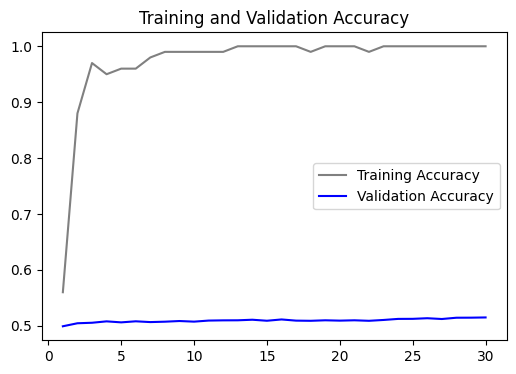

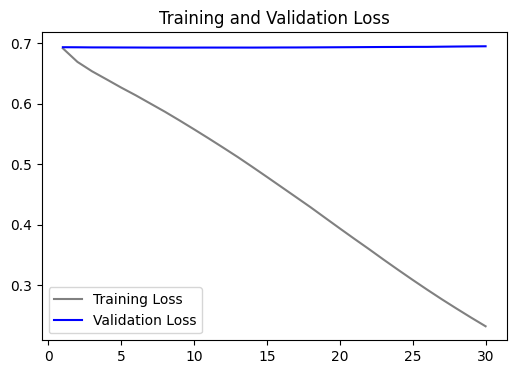

In [ ]:
accuracy = Model_1.history['acc']
val_accuracy = Model_1.history['val_acc']

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating model on test set

In [ ]:
test_model = load_model('my_model1_checkpoint.h5')
Model1_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

157/157 [==============================] - 0s 1ms/step - loss: 0.6933 - acc: 0.4980
Loss: 0.693
Accuracy: 0.498


The model with 100 training samples resulted an accuracy of 49.8%

Model 2 (1D convolution and Embedding Layer) Training - 1000, Validation - 10000 and Test - 5000

In [ ]:
num_words = 10000

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=1000, test_size=10000, random_state=42, stratify=labels)

_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [ ]:
train_texts.shape

(1000, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

In [ ]:

model = Sequential()

maxlen = 150
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 8)            80000     
                                                                 
 conv1d (Conv1D)             (None, 148, 512)          12800     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 256)          

In [ ]:
checkpoint_path = 'my_model2_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Model_2 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=[checkpoint])

Epoch 1/30
32/32 [==============================] - 4s 75ms/step - loss: 0.6938 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5001
Epoch 2/30
32/32 [==============================] - 2s 66ms/step - loss: 0.6944 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 3/30
32/32 [==============================] - 2s 66ms/step - loss: 0.6933 - accuracy: 0.4860 - val_loss: 0.6931 - val_accuracy: 0.5255
Epoch 4/30
32/32 [==============================] - 2s 66ms/step - loss: 0.6927 - accuracy: 0.5210 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 5/30
32/32 [==============================] - 2s 66ms/step - loss: 0.6934 - accuracy: 0.4750 - val_loss: 0.6930 - val_accuracy: 0.5191
Epoch 6/30
32/32 [==============================] - 2s 65ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6930 - val_accuracy: 0.5180
Epoch 7/30
32/32 [==============================] - 2s 64ms/step - loss: 0.6926 - accuracy: 0.5050 - val_loss: 0.6929 - val_accuracy: 0.5160
Epoch 8/30
32

Plotting the Training and Validation accuracy and Loss graphs

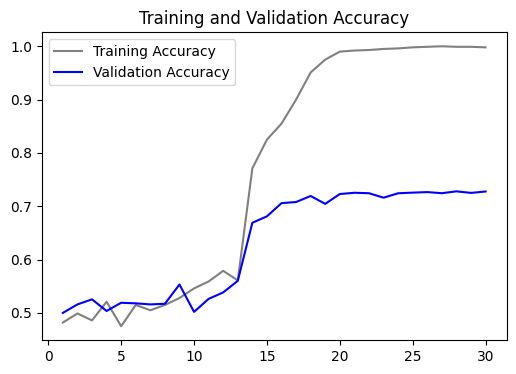

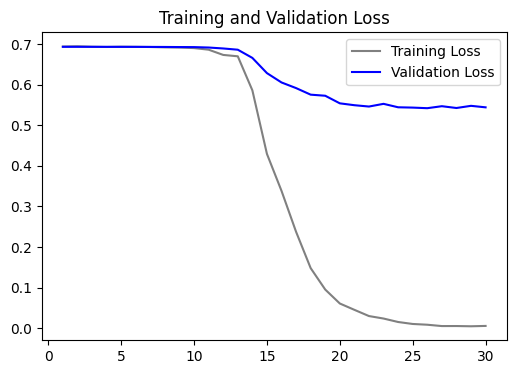

In [ ]:
accuracy = Model_2.history['accuracy']
val_accuracy = Model_2.history['val_accuracy']

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('my_model2_checkpoint.h5')
Model3_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

157/157 [==============================] - 1s 5ms/step - loss: 0.5240 - accuracy: 0.7450
Loss: 0.524
Accuracy: 0.745


 increase in  the training sample size to 1000 and by using 1D Conv with Embedding layer resulted an accuracy of 74.5%

Model 3 Training - 25000, Validation - 10000 and Test - 5000

In [ ]:
num_words = 10000

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=25000, test_size=10000, random_state=42, stratify=labels)

_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [ ]:
train_texts.shape

(25000, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

Introducing an extra layer to both the 1DConv and Dense networks. The embedding vector dimension is now 12, and we've added dropout layers to all input layers to prevent overfitting.

In [ ]:
model = Sequential()

maxlen = 150
model.add(Embedding(10000, 12, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


adam = keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 12)           120000    
                                                                 
 conv1d_3 (Conv1D)           (None, 148, 512)          18944     
                                                                 
 dropout_1 (Dropout)         (None, 148, 512)          0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 74, 512)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 72, 256)           393472    
                                                                 
 dropout_2 (Dropout)         (None, 72, 256)           0         
                                                      

In [ ]:
checkpoint_path = 'my_model3_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Model_3 = model.fit(train_texts, train_labels,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_texts, val_labels),
                    callbacks=[checkpoint])

Epoch 1/50
391/391 [==============================] - 23s 52ms/step - loss: 0.6934 - accuracy: 0.5062 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/50
391/391 [==============================] - 20s 51ms/step - loss: 0.5671 - accuracy: 0.6748 - val_loss: 0.5349 - val_accuracy: 0.8282
Epoch 3/50
391/391 [==============================] - 20s 50ms/step - loss: 0.3341 - accuracy: 0.8572 - val_loss: 0.4879 - val_accuracy: 0.8329
Epoch 4/50
391/391 [==============================] - 20s 50ms/step - loss: 0.2718 - accuracy: 0.8905 - val_loss: 0.4452 - val_accuracy: 0.8341
Epoch 5/50
391/391 [==============================] - 20s 50ms/step - loss: 0.2309 - accuracy: 0.9082 - val_loss: 0.4350 - val_accuracy: 0.8475
Epoch 6/50
391/391 [==============================] - 20s 50ms/step - loss: 0.2011 - accuracy: 0.9228 - val_loss: 0.4362 - val_accuracy: 0.8408
Epoch 7/50
391/391 [==============================] - 20s 50ms/step - loss: 0.1698 - accuracy: 0.9384 - val_loss: 0.4011 - val_accuracy:

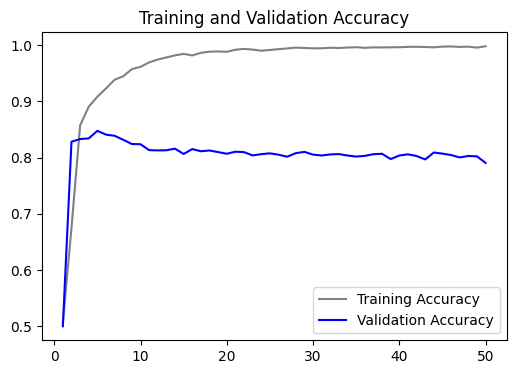

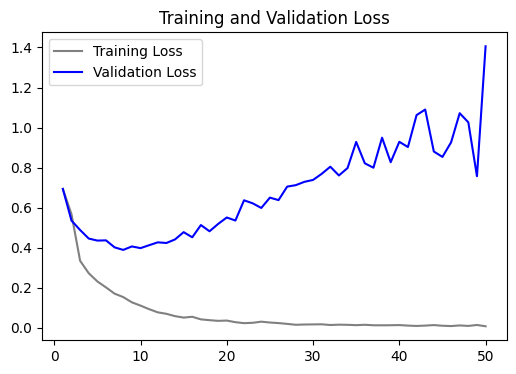

In [ ]:
accuracy = Model_3.history['accuracy']
val_accuracy = Model_3.history['val_accuracy']

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('my_model3_checkpoint.h5')
Model3_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

157/157 [==============================] - 1s 7ms/step - loss: 0.3119 - accuracy: 0.8996
Loss: 0.312
Accuracy: 0.900


We added more layers and Dropout to prevent overfitting. We also included two Dense layers with Dropout, using the Adam optimizer with a learning rate of 0.0002. With 25,000 training samples, the network achieved 90.00% accuracy.

Model 4 Training - 35000, Validation - 10000 and Test - 5000

In [ ]:
num_words = 10000

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=35000, test_size=10000, random_state=42, stratify=labels)

_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [ ]:
train_texts.shape

(35000, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

embedding vector size from 12 to 14 .

In [ ]:
model = Sequential()

maxlen = 150
model.add(Embedding(10000, 14, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


adam = keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 14)           140000    
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 512)          22016     
                                                                 
 dropout_7 (Dropout)         (None, 148, 512)          0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 74, 512)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 72, 256)           393472    
                                                                 
 dropout_8 (Dropout)         (None, 72, 256)           0         
                                                      

In [ ]:
checkpoint_path = 'my_model4_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Model_4 = model.fit(train_texts, train_labels,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_texts, val_labels),
                    callbacks=[checkpoint])

Epoch 1/50
547/547 [==============================] - 30s 51ms/step - loss: 0.6721 - accuracy: 0.5421 - val_loss: 0.6193 - val_accuracy: 0.7689
Epoch 2/50
547/547 [==============================] - 27s 50ms/step - loss: 0.3835 - accuracy: 0.8301 - val_loss: 0.4829 - val_accuracy: 0.8465
Epoch 3/50
547/547 [==============================] - 27s 50ms/step - loss: 0.3008 - accuracy: 0.8745 - val_loss: 0.4762 - val_accuracy: 0.8487
Epoch 4/50
547/547 [==============================] - 27s 50ms/step - loss: 0.2640 - accuracy: 0.8926 - val_loss: 0.4379 - val_accuracy: 0.8547
Epoch 5/50
547/547 [==============================] - 27s 49ms/step - loss: 0.2348 - accuracy: 0.9070 - val_loss: 0.4270 - val_accuracy: 0.8512
Epoch 6/50
547/547 [==============================] - 27s 49ms/step - loss: 0.2135 - accuracy: 0.9166 - val_loss: 0.4090 - val_accuracy: 0.8514
Epoch 7/50
547/547 [==============================] - 27s 49ms/step - loss: 0.1910 - accuracy: 0.9268 - val_loss: 0.3835 - val_accuracy:

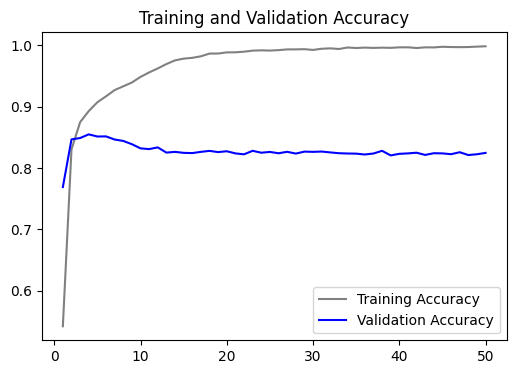

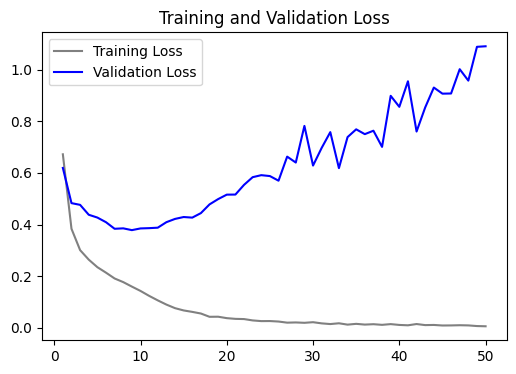

In [ ]:
accuracy = Model_4.history['accuracy']
val_accuracy = Model_4.history['val_accuracy']

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('my_model4_checkpoint.h5')
Model4_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

157/157 [==============================] - 1s 7ms/step - loss: 0.2785 - accuracy: 0.9246
Loss: 0.278
Accuracy: 0.925


An increse in the embedding vector dimension from 12 to 14 Model 4 resulted an accuracy of 92.6%

Considering the embedding vector dimension as a crucial hyperparameter in network building, it's evident that finding the right balance is essential. If set too high, the risk of overfitting increases, and vice versa. The choice of this parameter should align with the dataset size and the ultimate optimization goal.

Best models from all 4

In [ ]:
Models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
Loss = [0.693,0.524,0.312,0.278]
Accuracy = [0.498,0.745,0.900,0.925]

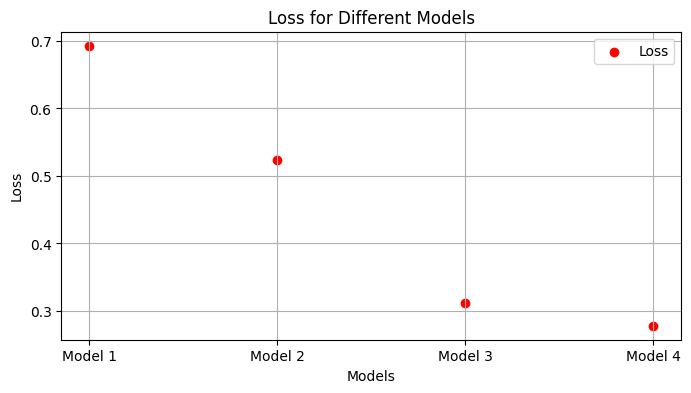

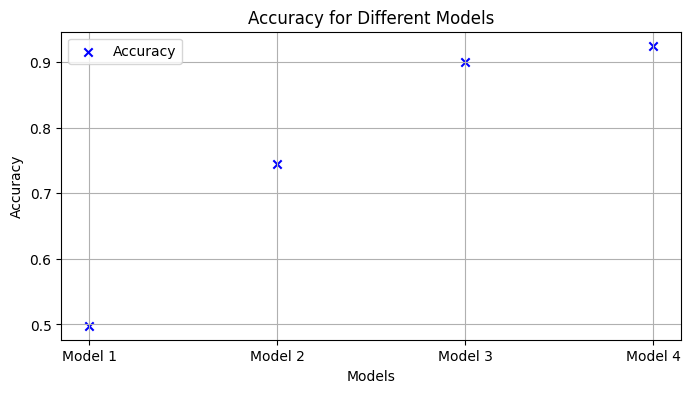

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(Models, Loss, color='red', label='Loss', marker='o')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Loss for Different Models')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 4))
plt.scatter(Models, Accuracy, color='blue', label='Accuracy', marker='x')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')
plt.grid(True)
plt.legend()
plt.show()


The Model 4 has highest accuracy amoung the 4 models with an accuracy of 92.6 %

PreTrained models

Pretrained Model GloVe

Uploading the IMDB .tar file to the Colab environment.

In [8]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4411k      0  0:00:18  0:00:18 --:--:-- 4029k


In [9]:
!rm -r aclImdb/train/unsup

Establishing directories and appending data from both the Negative (Neg) and Positive (Pos) classes.

In [10]:
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [11]:
print(len(texts))

25000


PreTrained Model 1

In [12]:
maxlen = 150
training_samples = 100
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [ ]:
x_train.shape

(100, 150)

In [ ]:
x_val.shape

(10000, 150)

Connecting to Google Drive to access the glove.txt file.

In [13]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
glove_dir = '/content/gdrive/My Drive/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Creating a embedding matrix

In [15]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:

            embedding_matrix[i] = embedding_vector

Buliding Network

In [16]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Model Summary

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


Running The model

In [ ]:
checkpoint_path = 'my_Premodel1_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Pre_Model_1 = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 0.7086 - accuracy: 0.5000 - val_loss: 0.7022 - val_accuracy: 0.5087
Epoch 2/50
4/4 [==============================] - 5s 2s/step - loss: 0.7053 - accuracy: 0.5000 - val_loss: 0.7007 - val_accuracy: 0.5070
Epoch 3/50
4/4 [==============================] - 5s 2s/step - loss: 0.7028 - accuracy: 0.5100 - val_loss: 0.6997 - val_accuracy: 0.5071
Epoch 4/50
4/4 [==============================] - 5s 2s/step - loss: 0.7008 - accuracy: 0.5200 - val_loss: 0.6987 - val_accuracy: 0.5073
Epoch 5/50
4/4 [==============================] - 5s 2s/step - loss: 0.6992 - accuracy: 0.5300 - val_loss: 0.6977 - val_accuracy: 0.5056
Epoch 6/50
4/4 [==============================] - 5s 2s/step - loss: 0.6973 - accuracy: 0.5400 - val_loss: 0.6970 - val_accuracy: 0.5039
Epoch 7/50
4/4 [==============================] - 5s 2s/step - loss: 0.6956 - accuracy: 0.5400 - val_loss: 0.6965 - val_accuracy: 0.5034
Epoch 8/50
4/4 [=========================

Visualizing the Training and Validation Loss/Accuracy

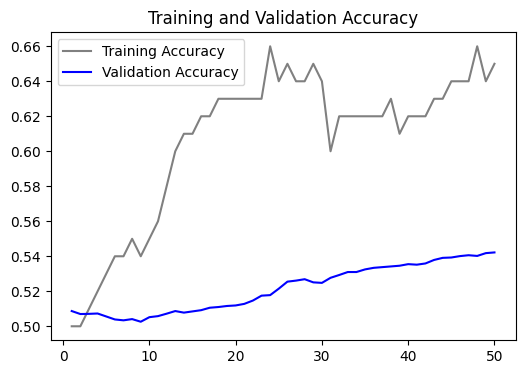

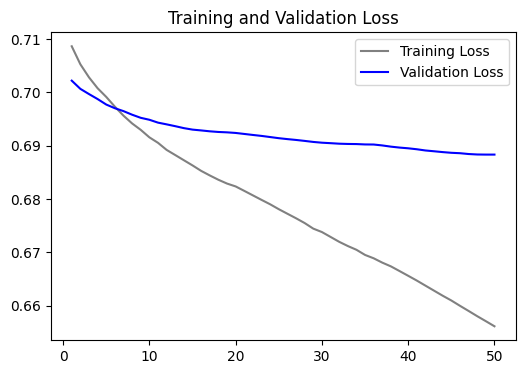

In [ ]:
accuracy = Pre_Model_1.history['accuracy']
val_accuracy = Pre_Model_1.history['val_accuracy']

loss = Pre_Model_1.history["loss"]
val_loss = Pre_Model_1.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Loading the test data for model evaluation

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

In [ ]:
x_test.shape

(5000, 150)

In [ ]:
test_model = load_model('my_Premodel1_checkpoint.h5')
PreModel1_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel1_Results[0]:.3f}')
print(f'Accuracy: {PreModel1_Results[1]:.3f}')

157/157 [==============================] - 3s 15ms/step - loss: 0.6569 - accuracy: 0.6990
Loss: 0.657
Accuracy: 0.699


The pretrained model 1 resulted an accuracy 69.9%.

PreTrained Model 2

In [51]:
maxlen = 150
training_samples = 1000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [ ]:
x_train.shape

(1000, 150)

In [ ]:
x_val.shape

(10000, 150)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 150, 512)          1255424   
                                                                 
 dropout (Dropout)           (None, 150, 512)          0         
                                                                 
 lstm_2 (LSTM)               (None, 150, 256)          787456    
                                                                 
 dropout_1 (Dropout)         (None, 150, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_2 (Dropout)         (None, 150, 128)         

In [ ]:
checkpoint_path = 'my_Premodel2_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Pre_Model_2 = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/40
32/32 [==============================] - 129s 4s/step - loss: 0.6948 - accuracy: 0.4840 - val_loss: 0.6943 - val_accuracy: 0.4987
Epoch 2/40
32/32 [==============================] - 112s 4s/step - loss: 0.6952 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 3/40
32/32 [==============================] - 113s 4s/step - loss: 0.6946 - accuracy: 0.5080 - val_loss: 0.6935 - val_accuracy: 0.4987
Epoch 4/40
32/32 [==============================] - 113s 4s/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 5/40
32/32 [==============================] - 115s 4s/step - loss: 0.6923 - accuracy: 0.5210 - val_loss: 0.6957 - val_accuracy: 0.4987
Epoch 6/40
32/32 [==============================] - 112s 4s/step - loss: 0.6963 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 7/40
32/32 [==============================] - 112s 4s/step - loss: 0.6951 - accuracy: 0.4980 - val_loss: 0.6941 - val_accuracy: 0.4987
Epoch 8/40
32

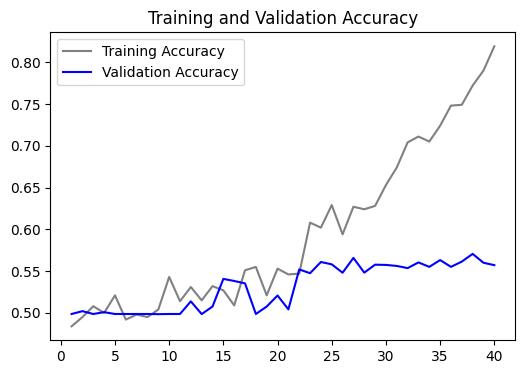

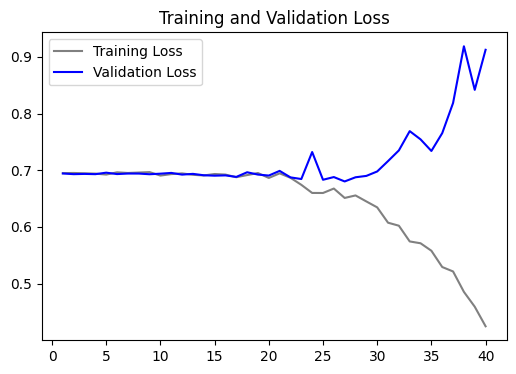

In [ ]:
accuracy = Pre_Model_2.history['accuracy']
val_accuracy = Pre_Model_2.history['val_accuracy']

loss = Pre_Model_2.history["loss"]
val_loss = Pre_Model_2.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

In [ ]:
test_model = load_model('my_Premodel2_checkpoint.h5')
PreModel1_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel2_Results[0]:.3f}')
print(f'Accuracy: {PreModel2_Results[1]:.3f}')

157/157 [==============================] - 47s 286ms/step - loss: 0.6135 - accuracy: 0.7134
Loss: 0.614
Accuracy: 0.713


The pretrained model 2 has an increase in the accuracy which is 71.3%

PreTrained model 3

In [18]:
maxlen = 150
training_samples = 10000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [19]:
x_train.shape

(10000, 150)

In [20]:
x_val.shape

(10000, 150)

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           42240     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,056,833
Trainable params: 56,833
Non-t

In [23]:
checkpoint_path = 'my_Premodel3_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Pre_Model_3 = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/40
157/157 [==============================] - 39s 211ms/step - loss: 0.6957 - accuracy: 0.5059 - val_loss: 0.6937 - val_accuracy: 0.4996
Epoch 2/40
157/157 [==============================] - 32s 203ms/step - loss: 0.6939 - accuracy: 0.5001 - val_loss: 0.6934 - val_accuracy: 0.5017
Epoch 3/40
157/157 [==============================] - 31s 200ms/step - loss: 0.6937 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4981
Epoch 4/40
157/157 [==============================] - 32s 201ms/step - loss: 0.6933 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.5037
Epoch 5/40
157/157 [==============================] - 31s 201ms/step - loss: 0.6934 - accuracy: 0.5022 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 6/40
157/157 [==============================] - 31s 200ms/step - loss: 0.6925 - accuracy: 0.5141 - val_loss: 0.6934 - val_accuracy: 0.5040
Epoch 7/40
157/157 [==============================] - 32s 202ms/step - loss: 0.6921 - accuracy: 0.5177 - val_loss: 0.6935 - val_ac

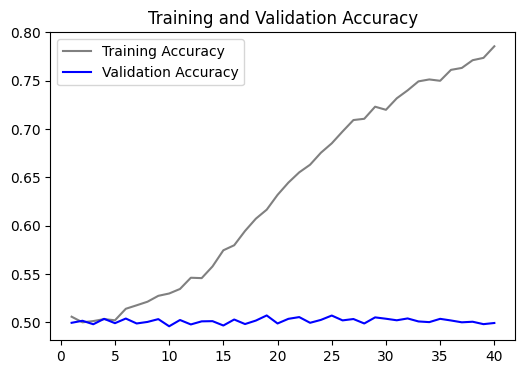

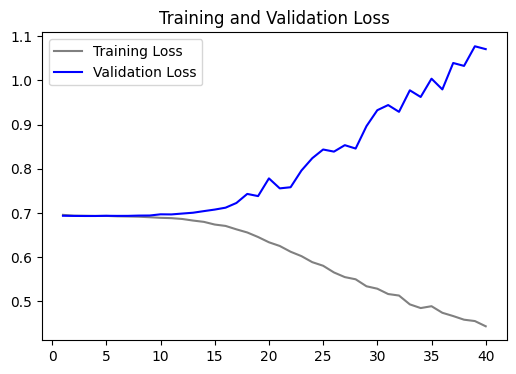

In [24]:
accuracy = Pre_Model_3.history['accuracy']
val_accuracy = Pre_Model_3.history['val_accuracy']

loss = Pre_Model_3.history["loss"]
val_loss = Pre_Model_3.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [27]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

In [28]:
test_model = load_model('my_Premodel3_checkpoint.h5')
PreModel3_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel3_Results[0]:.3f}')
print(f'Accuracy: {PreModel3_Results[1]:.3f}')

157/157 [==============================] - 5s 30ms/step - loss: 0.6908 - accuracy: 0.5854
Loss: 0.691
Accuracy: 0.585


PreTrained Model 4

In [29]:
maxlen = 150
training_samples = 15000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [30]:
x_train.shape

(15000, 150)

In [31]:
x_val.shape

(10000, 150)

In [32]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_3 (LSTM)               (None, 150, 256)          365568    
                                                                 
 dropout_1 (Dropout)         (None, 150, 256)          0         
                                                                 
 lstm_4 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_2 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 256)              

In [34]:
checkpoint_path = 'my_Premodel4_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Pre_Model_4 = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/40
235/235 [==============================] - 152s 623ms/step - loss: 0.6903 - accuracy: 0.5264 - val_loss: 0.6749 - val_accuracy: 0.5817
Epoch 2/40
235/235 [==============================] - 142s 604ms/step - loss: 0.6727 - accuracy: 0.5885 - val_loss: 0.6669 - val_accuracy: 0.5933
Epoch 3/40
235/235 [==============================] - 144s 612ms/step - loss: 0.6598 - accuracy: 0.6083 - val_loss: 0.6578 - val_accuracy: 0.6143
Epoch 4/40
235/235 [==============================] - 143s 610ms/step - loss: 0.6417 - accuracy: 0.6326 - val_loss: 0.6461 - val_accuracy: 0.6263
Epoch 5/40
235/235 [==============================] - 142s 603ms/step - loss: 0.6394 - accuracy: 0.6359 - val_loss: 0.6230 - val_accuracy: 0.6537
Epoch 6/40
235/235 [==============================] - 138s 589ms/step - loss: 0.6274 - accuracy: 0.6509 - val_loss: 0.6138 - val_accuracy: 0.6606
Epoch 7/40
235/235 [==============================] - 144s 614ms/step - loss: 0.6140 - accuracy: 0.6644 - val_loss: 0.6235 -

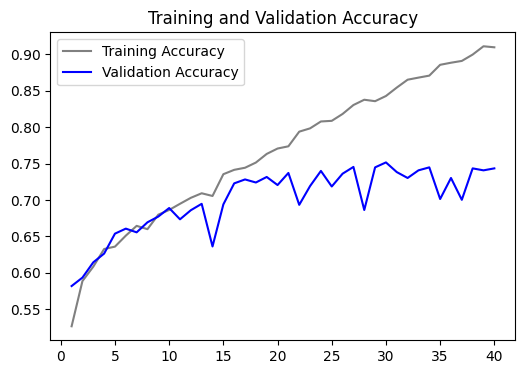

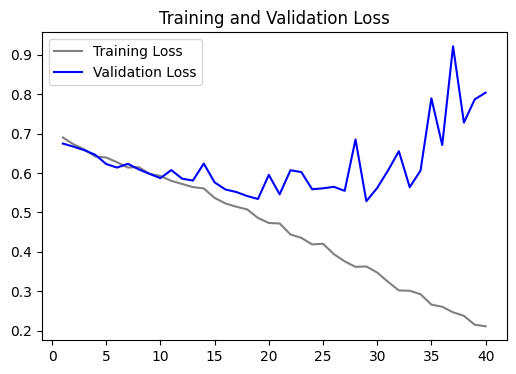

In [35]:
accuracy = Pre_Model_4.history['accuracy']
val_accuracy = Pre_Model_4.history['val_accuracy']

loss = Pre_Model_4.history["loss"]
val_loss = Pre_Model_4.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [36]:
test_model = load_model('my_Premodel4_checkpoint.h5')
PreModel4_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel4_Results[0]:.3f}')
print(f'Accuracy: {PreModel4_Results[1]:.3f}')

157/157 [==============================] - 22s 135ms/step - loss: 1.0102 - accuracy: 0.5054
Loss: 1.010
Accuracy: 0.505


Increase in the training samples and complexity resulted in poor perfomance of the models

PreTrained Model 5

reducing complexity

In [37]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(128))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,150,529
Trainable params: 150,529
Non-

In [39]:
checkpoint_path = 'my_Premodel5_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             monitor = "val_loss"
                            )

# Train the model
Pre_Model_5 = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/40
235/235 [==============================] - 40s 160ms/step - loss: 0.6905 - accuracy: 0.5362 - val_loss: 0.6722 - val_accuracy: 0.5778
Epoch 2/40
235/235 [==============================] - 38s 161ms/step - loss: 0.6691 - accuracy: 0.5851 - val_loss: 0.6627 - val_accuracy: 0.5912
Epoch 3/40
235/235 [==============================] - 38s 160ms/step - loss: 0.6480 - accuracy: 0.6179 - val_loss: 0.6190 - val_accuracy: 0.6544
Epoch 4/40
235/235 [==============================] - 37s 160ms/step - loss: 0.6205 - accuracy: 0.6514 - val_loss: 0.6440 - val_accuracy: 0.6160
Epoch 5/40
235/235 [==============================] - 37s 158ms/step - loss: 0.5958 - accuracy: 0.6711 - val_loss: 0.5932 - val_accuracy: 0.6819
Epoch 6/40
235/235 [==============================] - 38s 161ms/step - loss: 0.5679 - accuracy: 0.6961 - val_loss: 0.5915 - val_accuracy: 0.6706
Epoch 7/40
235/235 [==============================] - 38s 162ms/step - loss: 0.5451 - accuracy: 0.7151 - val_loss: 0.5573 - val_ac

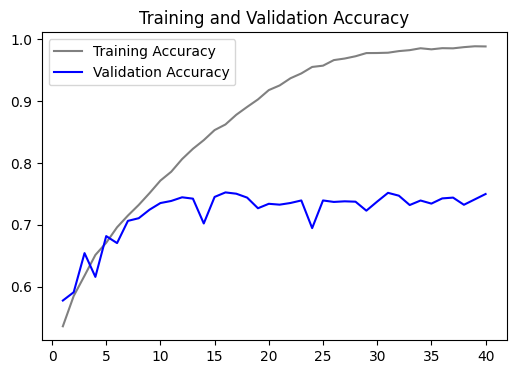

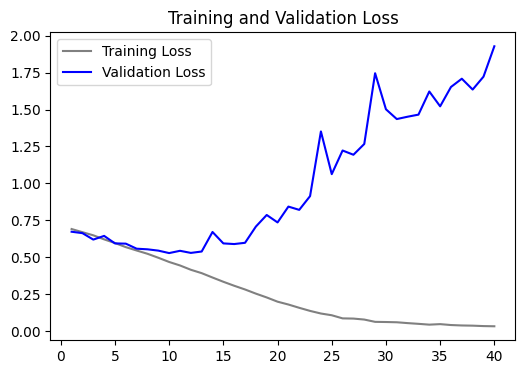

In [40]:
accuracy = Pre_Model_5.history['accuracy']
val_accuracy = Pre_Model_5.history['val_accuracy']

loss = Pre_Model_5.history["loss"]
val_loss = Pre_Model_5.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [42]:
test_model = load_model('my_Premodel5_checkpoint.h5')
PreModel5_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel5_Results[0]:.3f}')
print(f'Accuracy: {PreModel5_Results[1]:.3f}')

157/157 [==============================] - 6s 35ms/step - loss: 0.9620 - accuracy: 0.5028
Loss: 0.962
Accuracy: 0.503


In [47]:
Models = ['PreTrained1','PreTrained2','PreTrained3','PreTrained4','PreTrained5']
Loss = [0.657,0.614,0.691,1.00, 0.962]
Accuracy = [0.699,0.713,0.585,0.50,0.503]

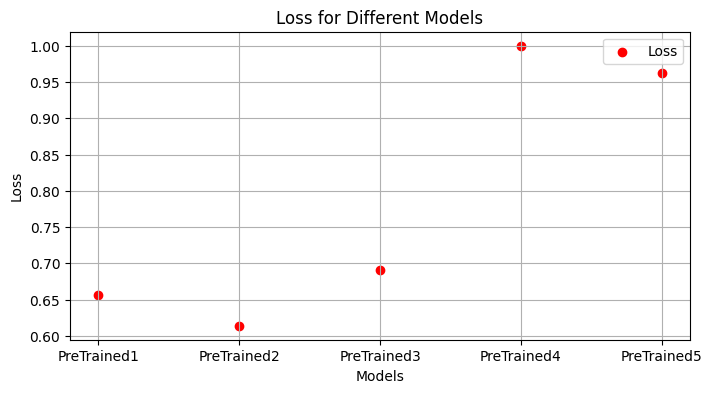

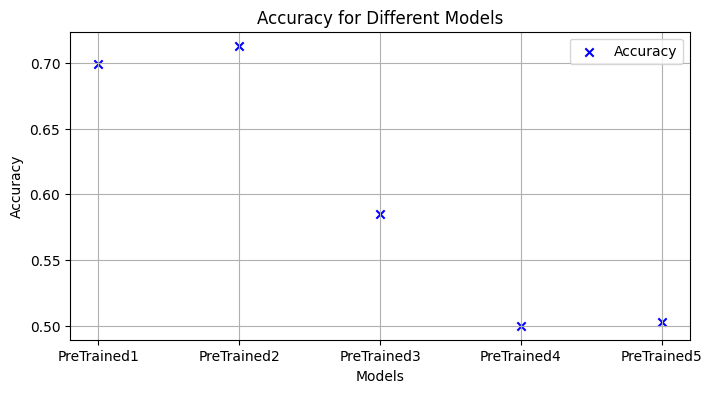

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.scatter(Models, Loss, color='red', label='Loss', marker='o')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Loss for Different Models')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 4))
plt.scatter(Models, Accuracy, color='blue', label='Accuracy', marker='x')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')
plt.grid(True)
plt.legend()
plt.show()
